##  Análisis de reseñas y sentimiento



### 0. Importar liberías

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import datasets as ds
import math

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

import pickle


## Amazon dataset
### 1. Carga de información

In [2]:
amazon_df = ds.feel_df(50000)


Se cargaron 50000 reseñas


In [3]:
amazon_df.head(10)

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,"Chrissy K. McVay ""Writer""",8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,"KerrLines ""&#34;Movies,Music,Theatre&#34;""",1/1,3.0,1188345600,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess..."
5,B003AI2VGA,A3QYDL5CDNYN66,"abra ""a devoted reader""",0/0,2.0,1229040000,Pretty pointless fictionalization,The murders in Juarez are real. This movie is ...
6,B003AI2VGA,AQJVNDW6YZFQS,Charles R. Williams,3/11,1.0,1164153600,"This is junk, stay away","Mexican men are macho rapists, gangsters or in..."
7,B00006HAXW,AD4CDZK7D31XP,Anthony Accordino,64/65,5.0,1060473600,A Rock N Roll History Lesson,"Over the past few years, public television has..."
8,B00006HAXW,A3Q4S5DFVPB70D,Joseph P. Aiello,26/26,5.0,1041292800,A MUST-HAVE video if you grew up in the 50's...,I recvd this video (DVD version) as a Christma...
9,B00006HAXW,A2P7UB02HAVEPB,"""bruce_from_la""",24/24,5.0,1061164800,If You Like DooWop You Gotta Have This DVD,"Wow! When I saw this show on PBS--that was it,..."


### 2. Exploración y limpieza

**2.1. Comprensión de datos**

In [4]:
print(f'El dataframe contiene {amazon_df.shape[0]} filas y {amazon_df.shape[1]} columnas.')

El dataframe contiene 50000 filas y 8 columnas.


**2.2. Identificando nulos y duplicados**


In [5]:
amazon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   productId    50000 non-null  object 
 1   userId       50000 non-null  object 
 2   profileName  50000 non-null  object 
 3   helpfulness  50000 non-null  object 
 4   score        50000 non-null  float64
 5   time         50000 non-null  int64  
 6   summary      50000 non-null  object 
 7   text         50000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 3.1+ MB


* `productId`: Identificador de pelicula (categórico)
* `userId`: Identificador del usuario (categórico)
* `profileName`: Nombre del usuario (categórico)
* `helpfulness`: Utilidad segun los usuarios (categórico)
* `score`: Puntuación (numérico)
* `time`: Tiempo de la película (numérico)
* `summary`: Opinión resumida (categórico)
* `text`: Opinion larga (categórico)

In [6]:
print(amazon_df.isnull().sum())

print("Duplicados:", amazon_df.duplicated().sum())

productId      0
userId         0
profileName    0
helpfulness    0
score          0
time           0
summary        0
text           0
dtype: int64
Duplicados: 32


**2.3. Eliminando información irrelevante**

In [7]:
amazon_df = amazon_df.drop_duplicates()
print("Duplicados:", amazon_df.duplicated().sum())


Duplicados: 0


* Eliminar columans irrelevantes

In [8]:
amazon_clean = amazon_df.drop(columns=['profileName', 'helpfulness', 'time'])

amazon_clean.head()


,productId,userId,score,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,3.0,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B003AI2VGA,A328S9RN3U5M68,3.0,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,5.0,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,3.0,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,3.0,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess..."


El texto sirve para estudio mas adelante pero solo se hara EDA de las 3 primeras columnas

### 3. Análisis univariante
**3.1. Dividir el Dataset en categoricos y numericos**

In [9]:
a_df_copy = amazon_clean.copy()
a_df_copy.dtypes.unique()

array([dtype('O'), dtype('float64')], dtype=object)

In [10]:
categorical_cols = ['productId', 'userId']
numerical_cols = ['score']

**3.2. Análisis sober variables categóricas**

In [11]:
# Reseñas por película
print(amazon_clean['productId'].value_counts().head(10))
print(f"Total de productos únicos: {amazon_clean['productId'].nunique()}")
print("------------------------------------------------------")
print(amazon_clean['userId'].value_counts().head(10))
print(f"Total de usuarios únicos: {amazon_clean['userId'].nunique()}")

productId
B002VL2PTU    669
B001NFNFMQ    648
B003DBEX6K    626
B000KKQNRO    608
B000ZLFALI    591
B000ZLFALS    591
B000063W82    589
B0001G6PZC    545
B0083SI986    530
B0014ERKO0    515
Name: count, dtype: int64
Total de productos únicos: 1539
------------------------------------------------------
userId
A3LZGLA88K0LA0    56
A2NJO6YE954DBH    54
ANCOMAI0I7LVG     54
A328S9RN3U5M68    53
A16CZRQL23NOIW    51
A35ZK3M8L9JUPX    50
A10ODC971MDHV8    50
ABO2ZI2Y5DQ9T     50
A1GGOC9PVDXW7Z    49
A7Y6AVS576M03     47
Name: count, dtype: int64
Total de usuarios únicos: 36409


Para visualiazr los datos categóricos solo se usara el TOP asi ya nos podemos hacer una idea con un gráfico con la información relevante

Top 10 productos graficados: 10
Top 10 usuarios graficados: 10


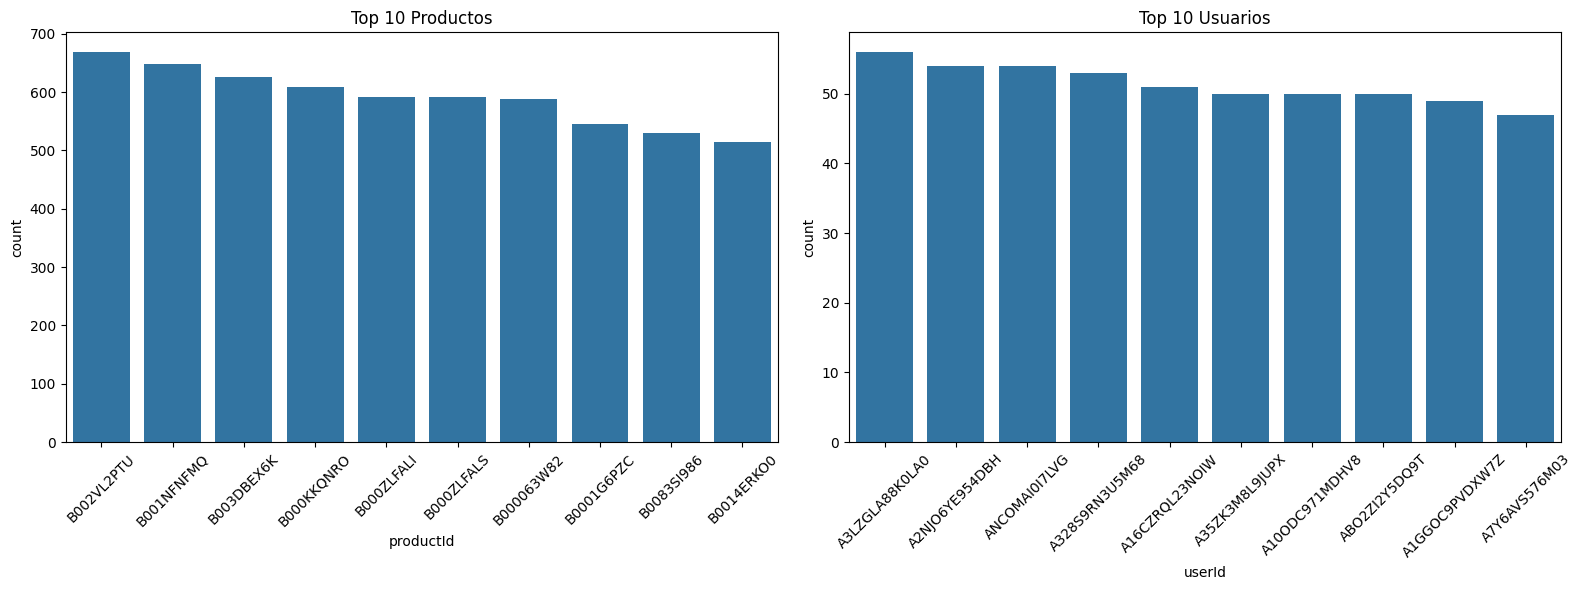

In [12]:
top_n_products = 10
top_n_users = 10

fig, axis = plt.subplots(1, 2, figsize=(16, 6))

# PRODUCTOS
top_products = amazon_clean['productId'].value_counts().head(top_n_products).index
sns.countplot(ax=axis[0], data=amazon_clean, x='productId', order=top_products)
axis[0].set_title("Top 10 Productos")
axis[0].tick_params(axis='x', rotation=45)
print("Top 10 productos graficados:", len(top_products))

# USUARIOS
top_users = amazon_clean['userId'].value_counts().head(top_n_users).index
sns.countplot(ax=axis[1], data=amazon_clean, x='userId', order=top_users)
axis[1].set_title("Top 10 Usuarios")
axis[1].tick_params(axis='x', rotation=45)
print("Top 10 usuarios graficados:", len(top_users))

plt.tight_layout()
plt.show()


* Las peliculas con mayor imapcto tienen entre 660 y 550 reseñas
* Los 10 usuarios con mas reseñas estan entre las 48 y 58 reseñas

**3.3. Análisis de las variables numéricas**

In [13]:
print(amazon_clean['score'].describe())

count    49968.000000
mean         4.118776
std          1.248836
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: score, dtype: float64


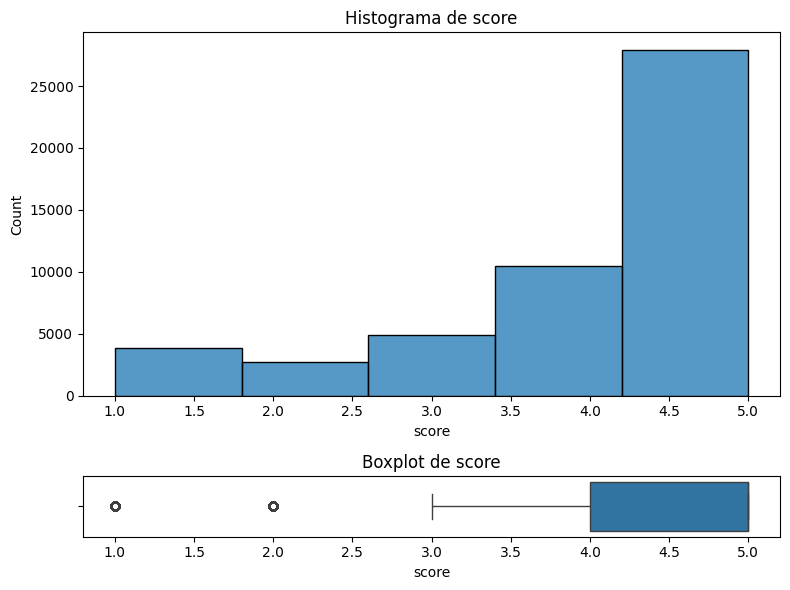

In [14]:
df_copy = amazon_clean
n = len(numerical_cols)
n_cols = 1  # solo un gráfico por columna (histograma + boxplot)
n_rows = n * 2  # fila par = hist, fila impar = boxplot

# Alternar alturas: filas pares grandes para histograma, impares pequeñas para boxplot
height_ratios = []
for _ in range(n):
    height_ratios.extend([6, 1])

fig, axis = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows), gridspec_kw={'height_ratios': height_ratios})

# Asegurar que axis sea 1D si solo hay una columna
if n == 1:
    axis = np.array(axis).reshape(-1)

for idx, col in enumerate(numerical_cols):
    # Limitar por percentil 90 (opcional)
    limite = df_copy[col].quantile(0.90)
    datos_filtrados = df_copy[df_copy[col] <= limite]

    row_hist = idx * 2
    row_box = row_hist + 1

    # Histograma
    sns.histplot(ax=axis[row_hist], data=datos_filtrados, x=col, bins=5, kde=False)
    axis[row_hist].set_title(f"Histograma de {col}")

    # Boxplot
    sns.boxplot(ax=axis[row_box], data=datos_filtrados, x=col)
    axis[row_box].set_title(f"Boxplot de {col}")

plt.tight_layout()
plt.show()


* La mayoría de reseñas se encuentran enre el 4.2 y el 5
* como se ve en el boxplot por ahi esta la media habiendo margen hasta 3. Por lo que reseñas de 1 y 2 son escasas

### 4. Análisis multivariante
**4.1. Codificación de valor categorico - numericos**

In [15]:
def plot_numerical_analisis_amazon(column, numerical_column, top_n=10, column_info=False):
   
    top_categories = amazon_clean[column].value_counts().head(top_n).index
    df_plot = amazon_clean[amazon_clean[column].isin(top_categories)].copy()

    
    columna_n = f"{column}_n"
    df_plot[columna_n] = pd.factorize(df_plot[column])[0]

    n = len(numerical_column)
    n_cols = 1
    n_rows = n * 2  # histograma + boxplot

    height_ratios = []
    for _ in range(n):
        height_ratios.extend([6, 1])

    fig, axis = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows), gridspec_kw={'height_ratios': height_ratios})

    if n == 1:
        axis = np.array(axis).reshape(-1)

    for idx, col in enumerate(numerical_column):
        limite = df_plot[col].quantile(0.90)
        datos_filtrados = df_plot[df_plot[col] <= limite]

        row_hist = idx * 2
        row_box = row_hist + 1

        # Gráfico de dispersión con regresión
        sns.regplot(ax=axis[row_hist], data=datos_filtrados, x=col, y=columna_n, scatter_kws={'alpha':0.5})
        axis[row_hist].set_ylabel(column)

        # Heatmap de correlación
        corr = datos_filtrados[[col, columna_n]].corr().rename(columns={columna_n: column}, index={columna_n: column})
        sns.heatmap(corr, annot=True, fmt=".2f", ax=axis[row_box], cbar=False)

    plt.tight_layout()
    plt.show()




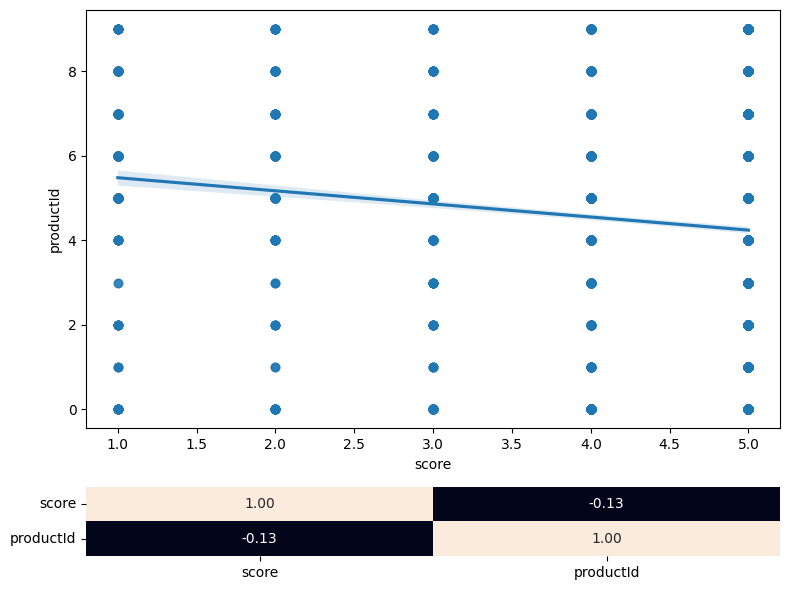

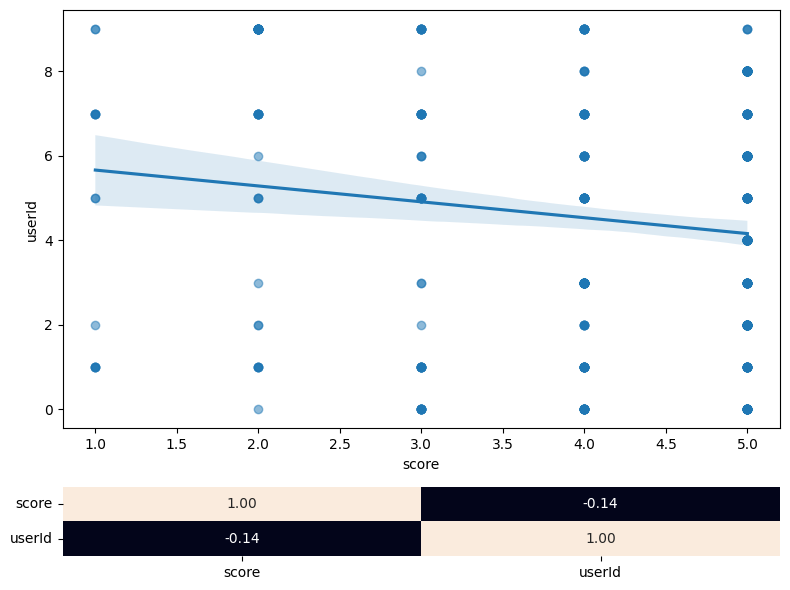

In [16]:

plot_numerical_analisis_amazon("productId", ["score"], top_n=10, column_info=True)
plot_numerical_analisis_amazon("userId", ["score"], top_n=10, column_info=True)

* No parecen tener relacion las pelis y usuarios con la puntuación

**4.2. Numerico-Numerico Análisis**

No se puede hacer ya que solo hay un numerico

**4.3. Categorico-Categorico Análisis**

<Figure size 1200x600 with 0 Axes>

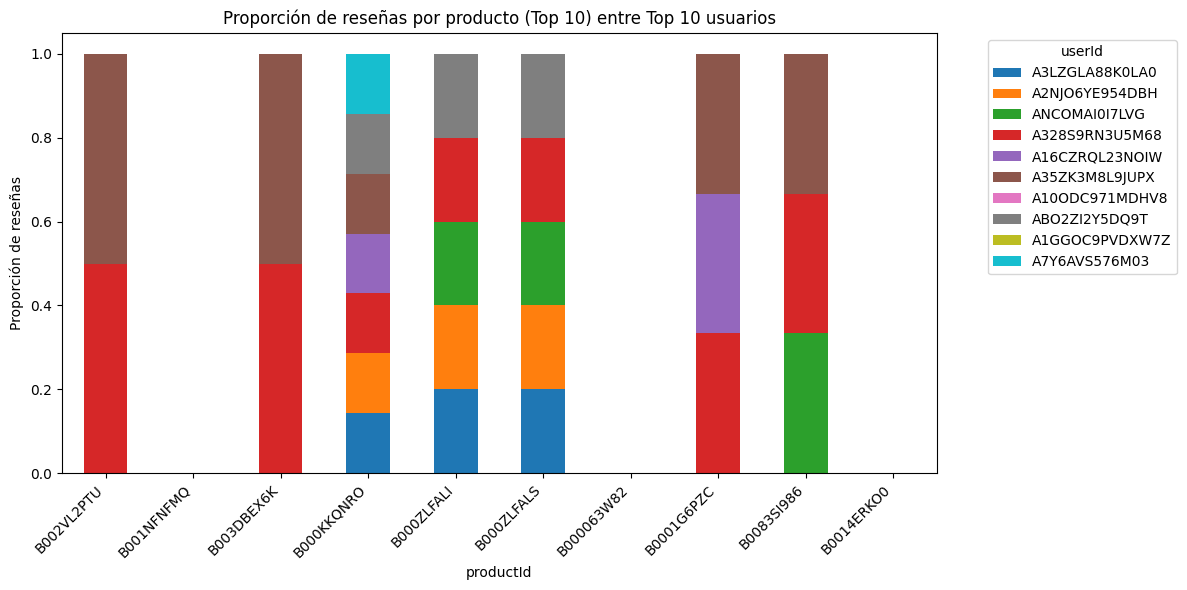

In [17]:
ct = pd.crosstab(df_copy['productId'], df_copy['userId'])

ct = ct.reindex(index=top_products, columns=top_users, fill_value=0)
ct_prop = ct.div(ct.sum(axis=1).replace(0,1), axis=0)  # evitar división por 0

# 3) Stacked bar (proporción) — más intuitivo para comparar productos
plt.figure(figsize=(12,6))
ct_prop.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title(f'Proporción de reseñas por producto (Top {top_n_products}) entre Top {top_n_users} usuarios')
plt.xlabel('productId')
plt.ylabel('Proporción de reseñas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='userId', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




* Hay peliculas con muchas reseñas pero que no fueron comentadas por ninguno de los top users (2da y 7ma)
* El usuario que mas peliculas top comento es el rojo
* La pelicula con mas comentarios de top users es la 4ta

### 5. Ingeniería de características

Puesto que hay otro dataset y se califican las reseñas como positivas, negativas o neutras vamos a ajustarlas, ademas de crear columnas para contar las reseñas por usuario y películas


In [18]:
def score_to_sentiment(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

amazon_clean['sentiment'] = amazon_clean['score'].apply(score_to_sentiment)


In [19]:
amazon_clean['reviews_per_product'] = amazon_clean.groupby('productId')['productId'].transform('count')
amazon_clean['reviews_per_user'] = amazon_clean.groupby('userId')['userId'].transform('count')

In [20]:
amazon_clean.head()

,productId,userId,score,summary,text,sentiment,reviews_per_product,reviews_per_user
0,B003AI2VGA,A141HP4LYPWMSR,3.0,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",neutral,7,27
1,B003AI2VGA,A328S9RN3U5M68,3.0,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...,neutral,7,53
2,B003AI2VGA,A1I7QGUDP043DG,5.0,This movie needed to be made.,The scenes in this film can be very disquietin...,positive,7,8
3,B003AI2VGA,A1M5405JH9THP9,3.0,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...,neutral,7,1
4,B003AI2VGA,ATXL536YX71TR,3.0,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess...",neutral,7,12


**5.1. Análisis de outliers**

In [21]:
def detectar_outliers_iqr(df, columnas):
    outliers = {}
    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        mask = (df[col] < lower) | (df[col] > upper)
        outliers[col] = df[mask][col]

        print(f"{col}: {mask.sum()} outliers detectados")

    return outliers

outliers_detectados = detectar_outliers_iqr(df_copy, numerical_cols + ['reviews_per_product', 'reviews_per_user'])


score: 6610 outliers detectados
reviews_per_product: 0 outliers detectados
reviews_per_user: 9032 outliers detectados


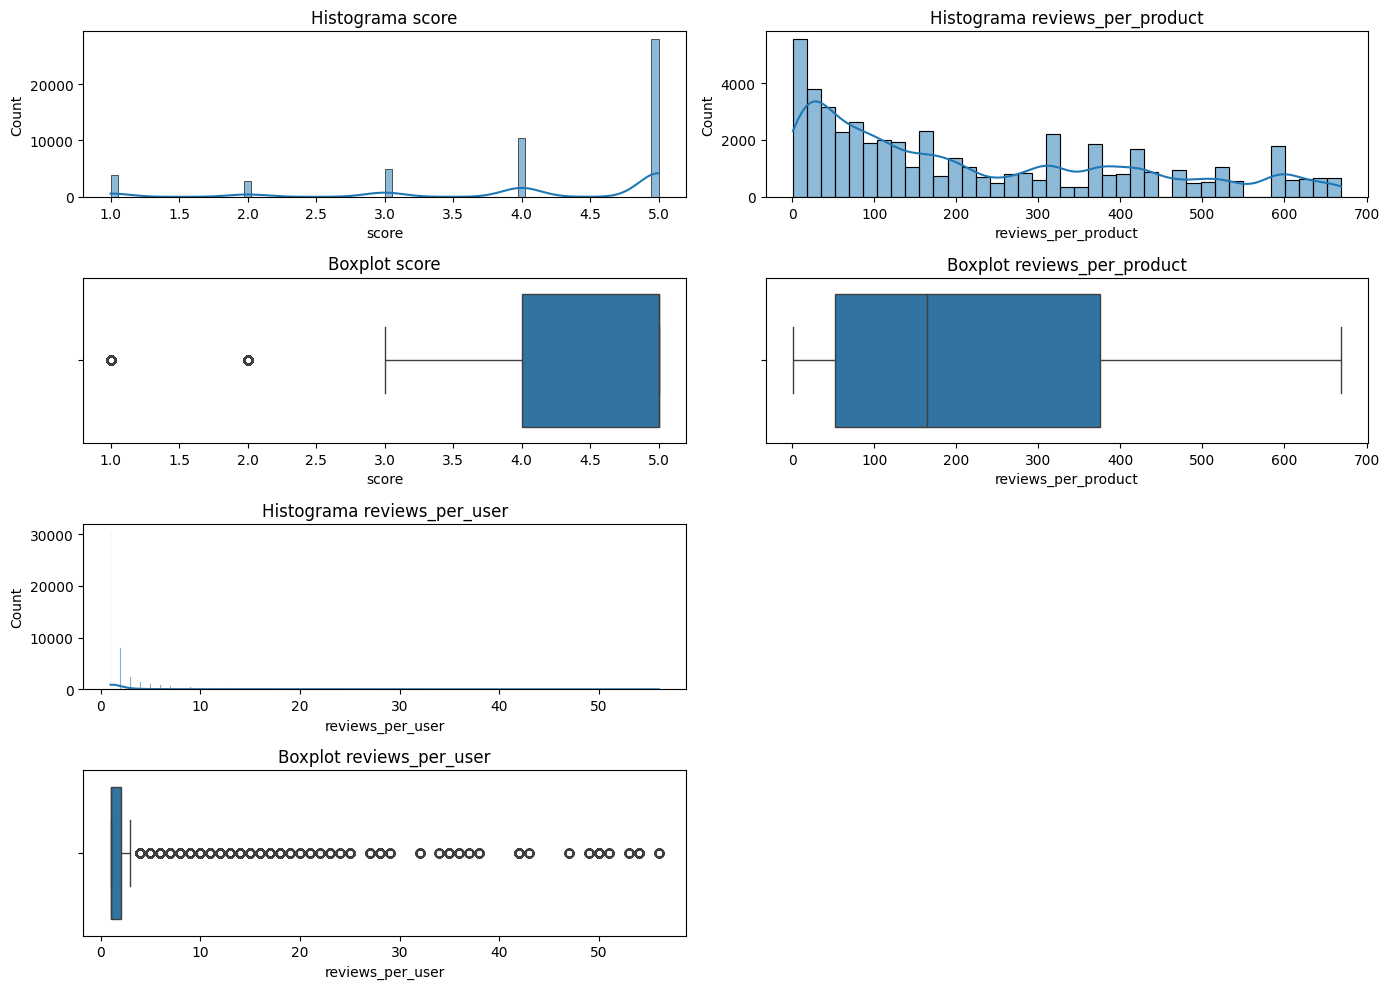

In [22]:
n = len(numerical_cols) + 2  # +2 por las nuevas columnas
n_cols = 2
n_rows = math.ceil(n / n_cols) * 2

fig, axis = plt.subplots(n_rows, n_cols, figsize=(14, 2.5 * n_rows))

axis = np.array(axis)
if axis.ndim == 1:
    axis = axis.reshape(-1, n_cols)

for idx, col in enumerate(numerical_cols + ['reviews_per_product', 'reviews_per_user']):
    datos = df_copy[col]

    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1

    # Histograma
    sns.histplot(ax=axis[row_hist, col_pos], data=datos, kde=True)
    axis[row_hist, col_pos].set_title(f"Histograma {col}")

    # Boxplot
    sns.boxplot(ax=axis[row_box, col_pos], data=datos, orient='h')
    axis[row_box, col_pos].set_title(f"Boxplot {col}")

# Eliminar gráficos vacíos
for idx in range(n, (n_rows // 2) * n_cols):
    grid_pos = idx // n_cols
    col_pos = idx % n_cols
    row_hist = grid_pos * 2
    row_box = row_hist + 1
    fig.delaxes(axis[row_hist, col_pos])
    fig.delaxes(axis[row_box, col_pos])

plt.tight_layout()
plt.show()


* Aunque se vean outliers son de datos que deben manejarse diferentes, los reviews por usuario sirve para tener en cuenta grupos de usuarios mas cactivos o menos activos . En el aso de score al ser casos de puntajes tampoco es necesario quitarlos.

## IMDb ES/EN Dataset
### 1. Carga de información

In [23]:
df_imdb = ds.review_dataset()

In [24]:
df_imdb.head(10)

,Unnamed: 0,review_en,review_es,sentiment,sentimiento
0,0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo
5,5,"Probably my all-time favorite movie, a story o...",Probablemente mi película favorita de todos lo...,positive,positivo
6,6,I sure would like to see a resurrection of a u...,Seguro que me gustaría ver una resurrección de...,positive,positivo
7,7,"This show was an amazing, fresh & innovative i...","Este espectáculo fue una idea increíble, fresc...",negative,negativo
8,8,Encouraged by the positive comments about this...,Alentados por los comentarios positivos sobre ...,negative,negativo
9,9,If you like original gut wrenching laughter yo...,"Si te gusta la risa original desgarradora, te ...",positive,positivo


### 2. Exploración y limpieza

**2.1. Comprensión de datos**

In [25]:
print(f'El dataframe contiene {df_imdb.shape[0]} filas y {df_imdb.shape[1]} columnas.')

El dataframe contiene 50000 filas y 5 columnas.


**2.2. Identificando nulos y duplicados**

In [26]:
df_imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   50000 non-null  int64 
 1   review_en    50000 non-null  object
 2   review_es    50000 non-null  object
 3   sentiment    50000 non-null  object
 4   sentimiento  50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [27]:
print(df_imdb.isnull().sum())

print("Duplicados:", df_imdb.duplicated().sum())

Unnamed: 0     0
review_en      0
review_es      0
sentiment      0
sentimiento    0
dtype: int64
Duplicados: 0


**2.3. Eliminando información irrelevante**

In [28]:
df_imdb = df_imdb.drop(columns=['Unnamed: 0' ])
df_imdb

,review_en,review_es,sentiment,sentimiento
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo
...,...,...,...,...
49995,I thought this movie did a down right good job...,Pensé que esta película hizo un buen trabajo a...,positive,positivo
49996,"Bad plot, bad dialogue, bad acting, idiotic di...","Mala parcela, mal diálogo, mala actuación, dir...",negative,negativo
49997,I am a Catholic taught in parochial elementary...,Soy católica enseñada en escuelas primarias pa...,negative,negativo
49998,I'm going to have to disagree with the previou...,Voy a tener que estar en desacuerdo con el com...,negative,negativo


### 3. Análisis univariante
**3.1. Dividir el Dataset en categoricos y numericos**

In [29]:
# Longitud de cada review en número de caracteres
df_imdb['review_len_en'] = df_imdb['review_en'].str.len()
df_imdb['review_len_es'] = df_imdb['review_es'].str.len()

df_imdb.head()

,review_en,review_es,sentiment,sentimiento,review_len_en,review_len_es
0,One of the other reviewers has mentioned that ...,Uno de los otros críticos ha mencionado que de...,positive,positivo,1725,2004
1,A wonderful little production. The filming tec...,Una pequeña pequeña producción.La técnica de f...,positive,positivo,962,1061
2,I thought this was a wonderful way to spend ti...,Pensé que esta era una manera maravillosa de p...,positive,positivo,902,989
3,Basically there's a family where a little boy ...,"Básicamente, hay una familia donde un niño peq...",negative,negativo,712,790
4,"Petter Mattei's ""Love in the Time of Money"" is...","El ""amor en el tiempo"" de Petter Mattei es una...",positive,positivo,1269,1406


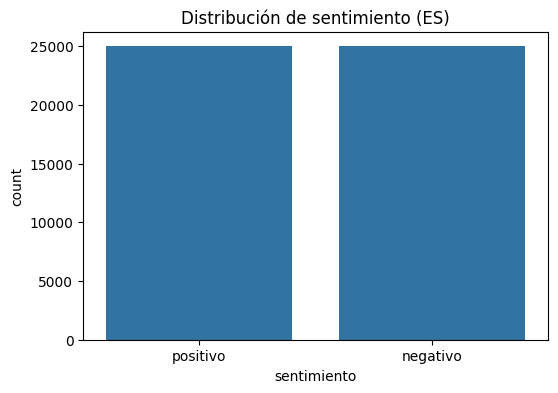

sentimiento
positivo    0.5
negativo    0.5
Name: proportion, dtype: float64


In [30]:
plt.figure(figsize=(6,4))
sns.countplot(x='sentimiento', data=df_imdb)
plt.title('Distribución de sentimiento (ES)')
plt.show()

print(df_imdb['sentimiento'].value_counts(normalize=True))

* Solo es necesario ver la distribución de sentimiento de un idioma ya que es lo mismo y se ve que estan repartidos equitativamente

### 5. Ingeniería de características

**5.1. Analisis de outliers**

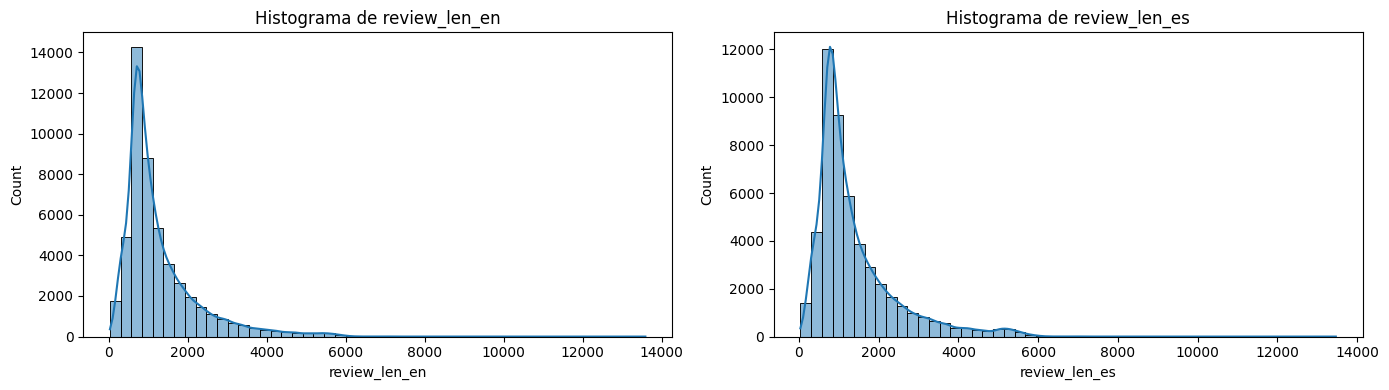

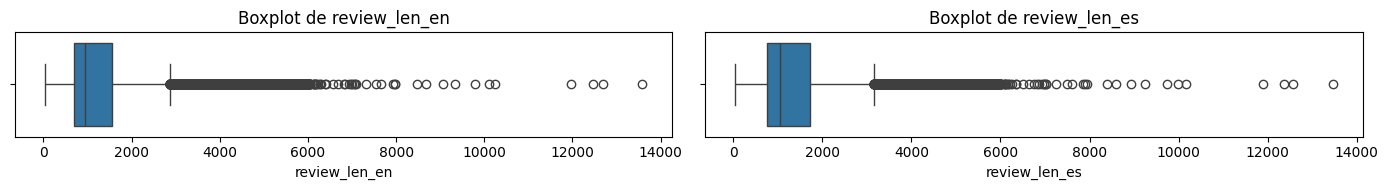

In [31]:
numerical_cols = ['review_len_en', 'review_len_es']

n = len(numerical_cols)
n_cols = 2
n_rows = (n + 1) // 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.histplot(df_imdb[col], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f'Histograma de {col}')

plt.tight_layout()
plt.show()

# Boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 2*n_rows))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    sns.boxplot(x=df_imdb[col], ax=axes[i])
    axes[i].set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()

* Las longitud de las reseñas parecen estar concentradas en los 100 caracteres, por lo que hay muchas cortas y una gran variedad de reseñas largas que hacen outliers
* Para proceder con el analisis de los textos se procedera a usar un limite por ejemplo 3500

In [32]:
max_len = 3500
df_imdb['review_en'] = df_imdb['review_en'].str[:max_len]
df_imdb['review_es'] = df_imdb['review_es'].str[:max_len]

* Tambien se deben quitar las que sean demasiado cortas ya que no aporta mucha información

In [33]:
df_imdb = df_imdb[df_imdb['review_es'].str.split().str.len() > 5]
df_imdb = df_imdb[df_imdb['review_en'].str.split().str.len() > 5]


In [34]:
df_imdb['review_es'] = df_imdb['review_es'].str.strip().str.lower()
df_imdb['review_en'] = df_imdb['review_en'].str.strip().str.lower()


**5.2. Dividir el train/test de marcos de datos**

In [35]:
X = df_imdb['review_en'] 
y = df_imdb['sentimiento']  # positivo/negativo sera el target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### 6. Transformar el texto en matriz

In [36]:
vec_model = CountVectorizer(stop_words = "english", max_features=5000)
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec = vec_model.transform(X_test)

### 7. Contruir el naive bayes

In [37]:
model = MultinomialNB()
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8468


### 8. Optimización del modelo

In [38]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

In [39]:
grid = RandomizedSearchCV(pipeline, hyperparams, scoring = "accuracy", n_iter = 20, random_state = 40)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

grid.best_params_

{'vectorizer__ngram_range': (1, 2),
 'vectorizer__max_features': None,
 'nb__alpha': np.float64(0.3)}

In [40]:
y_pred = mejor_modelo.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8797

Classification Report:
               precision    recall  f1-score   support

    negativo       0.87      0.89      0.88      5000
    positivo       0.89      0.86      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### 9. Guardar modelo

In [41]:
ruta = "../models/modelo_IMDB.pkl"

with open(ruta, "wb") as f:
    pickle.dump(mejor_modelo, f)

print(f"Modelo guardado en: {ruta}")

Modelo guardado en: ../models/modelo_IMDB.pkl


## aclIMDB dataset


### 1. Carga de información

In [42]:
train_texts, train_labels = ds.cargar_reseñas("../data/interim/feeling/aclImdb/train") ##texto de reseñas // ETIQUETA para positivo y negativo
test_texts, test_labels = ds.cargar_reseñas("../data/interim/feeling/aclImdb/test")

In [43]:
df_train = pd.DataFrame({
    "review": train_texts,
    "polarity": train_labels
})

df_test = pd.DataFrame({
    "review": test_texts,
    "polarity": test_labels
})

df_train.head()

,review,polarity
0,The scenes are fast-paced. the characters are ...,1
1,Why can't more directors these days create hor...,1
2,I've read countless of posts about this game b...,1
3,Maybe I loved this movie so much in part becau...,1
4,This is one of quite a few cartoons with Bugs ...,1


In [44]:
df_test.head()

,review,polarity
0,Surely the best film directed by Claude Lelouc...,1
1,I own the miniseries on DVD because I love thi...,1
2,This film is about aging Geisha in post war To...,1
3,Murder Over New York is one of the better Chan...,1
4,It's exactly what I expected from it. Relaxing...,1


### 2. Procesar texto y volver a separarlo

In [45]:
for df in [df_train, df_test]:
    df["review"] = df["review"].str.strip().str.lower()

#Esto por que ya estan en minusculas 
X_train = df_train["review"]
y_train = df_train["polarity"]
X_test = df_test["review"]
y_test = df_test["polarity"]

### 3. Transformar en matriz

In [46]:
vec_model = CountVectorizer(stop_words="english")
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec = vec_model.transform(X_test)

### 4. Contruir el naive bayes

In [47]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

y_pred_nb = nb_model.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.81968


### 5. Optimización

In [48]:
def evaluar_modelo(model, X_train_vec, X_test_vec, y_train, y_test, nombre="Modelo"):
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred)
    print(f"{nombre} Accuracy: {acc:.5f}")
    return model, y_pred

In [49]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}


In [50]:
# Naive Bayes simple
vec_model = CountVectorizer(stop_words="english")
X_train_vec = vec_model.fit_transform(X_train)
X_test_vec  = vec_model.transform(X_test)

nb_model = MultinomialNB()
nb_model, y_pred_nb = evaluar_modelo(nb_model, X_train_vec, X_test_vec, y_train, y_test, "Naive Bayes")

Naive Bayes Accuracy: 0.81968


In [51]:
# 5. Naive Bayes optimizado con Pipeline + RandomizedSearchCV
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

hyperparams = {
    'vectorizer__max_features': [1000, 2000, 3000, None],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'nb__alpha': np.linspace(0.1, 2.0, 20)
}

grid = RandomizedSearchCV(pipeline, hyperparams, scoring="accuracy", n_iter=20, random_state=42)
grid.fit(X_train, y_train)

best_nb_model = grid.best_estimator_
y_pred_best_nb = best_nb_model.predict(X_test)

print("Naive Bayes Optimizado Accuracy:", accuracy_score(y_test, y_pred_best_nb))
print("Mejores parámetros:", grid.best_params_)

Naive Bayes Optimizado Accuracy: 0.84056
Mejores parámetros: {'vectorizer__ngram_range': (1, 2), 'vectorizer__max_features': None, 'nb__alpha': np.float64(0.7)}


In [52]:
#Logistic Regression
log_model = LogisticRegression(max_iter=1000)
log_model, y_pred_log = evaluar_modelo(log_model, X_train_vec, X_test_vec, y_train, y_test, "Logistic Regression")

Logistic Regression Accuracy: 0.85864


In [53]:
acc_nb = accuracy_score(y_test, y_pred_best_nb)
acc_log = accuracy_score(y_test, y_pred_log)

if acc_log > acc_nb:
    modelo_final = log_model
    nombre_final = "Logistic Regression"
else:
    modelo_final = best_nb_model
    nombre_final = "Naive Bayes Optimizado"

print(f"Mejor modelo: {nombre_final} ({max(acc_nb, acc_log):.5f})")


Mejor modelo: Logistic Regression (0.85864)


### 6. Guardar el modelo

In [54]:
ruta = "../models/modelo_aclImdb.pkl"

with open(ruta, "wb") as f:
    pickle.dump(mejor_modelo, f)

print(f"Modelo guardado en: {ruta}")

Modelo guardado en: ../models/modelo_aclImdb.pkl


## Apliación del dataset de Amazón para estudio

**1. Cargar modelos**

In [55]:
with open("../models/modelo_aclImdb.pkl", "rb") as f:
    modelo_acl_imdb = pickle.load(f)

with open("../models/modelo_IMDB.pkl", "rb") as f:
    modelo_imdb_en = pickle.load(f)

In [62]:
df_amazon = amazon_df.copy()
df_amazon.head()

,productId,userId,profileName,helpfulness,score,time,summary,text
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic..."
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...
2,B003AI2VGA,A1I7QGUDP043DG,"Chrissy K. McVay ""Writer""",8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...
4,B003AI2VGA,ATXL536YX71TR,"KerrLines ""&#34;Movies,Music,Theatre&#34;""",1/1,3.0,1188345600,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess..."


* Se crean columnas usando los modelos creados

In [ ]:
df_amazon['sentiment_imdb_es'] = modelo_imdb_en.predict(df_amazon['text'])
df_amazon['sentiment_acl'] = modelo_acl_imdb.predict(df_amazon['text'])

# pasarla entre positivo y negativo dependiendo del score
df_amazon['sentiment_amazon'] = df_amazon['score'].apply(lambda x: 'positive' if x > 3 else 'negative')


# Promedio de sentimiento predicho por modelo IMDB 
sentiment_score_imdb = df_amazon.groupby('productId')['sentiment_imdb_es'].apply(
    lambda x: (x=='positive').mean()
).reset_index(name='avg_sentiment_imdb_es')

# Promedio de sentimiento predicho por ACL IMDB
sentiment_score_acl = df_amazon.groupby('productId')['sentiment_acl'].apply(
    lambda x: (x=='positive').mean()
).reset_index(name='avg_sentiment_acl')

# Promedio de rating / sentimiento de Amazon
amazon_stats = df_amazon.groupby('productId').agg(
    avg_rating=('score','mean'),
    avg_sentiment_amazon=('sentiment_amazon', lambda x: (x=='positive').mean()),
    n_reviews=('text','count')
).reset_index()

df_movie_features = amazon_stats.merge(sentiment_score_imdb, on='productId') \
                                .merge(sentiment_score_acl, on='productId')

print(df_movie_features.describe())


        avg_rating  avg_sentiment_amazon    n_reviews  avg_sentiment_imdb_es  \
count  1539.000000           1539.000000  1539.000000                 1539.0   
mean      3.952616              0.718675    32.467836                    0.0   
std       0.941729              0.310437    78.902432                    0.0   
min       1.000000              0.000000     1.000000                    0.0   
25%       3.500000              0.546700     2.000000                    0.0   
50%       4.117647              0.823529     6.000000                    0.0   
75%       4.642183              1.000000    24.000000                    0.0   
max       5.000000              1.000000   669.000000                    0.0   

       avg_sentiment_acl  
count             1539.0  
mean                 0.0  
std                  0.0  
min                  0.0  
25%                  0.0  
50%                  0.0  
75%                  0.0  
max                  0.0  


In [58]:
df_movie_features.head()

,productId,avg_rating,avg_sentiment_amazon,n_reviews,avg_sentiment_imdb_es,avg_sentiment_acl
0,0310582792,5.000000,1.000000,1,0.0,0.0
1,073600193X,5.000000,1.000000,3,0.0,0.0
2,0764004492,4.333333,0.666667,3,0.0,0.0
3,0767002652,4.750000,0.916667,24,0.0,0.0
4,076780046X,4.609375,0.890625,64,0.0,0.0


In [ ]:
X_amazon = df_amazon['text']
y_pred_imdb = modelo_imdb_en.predict(X_amazon)

In [60]:
unique, counts = np.unique(y_pred_imdb, return_counts=True)
print(dict(zip(unique, counts)))

{np.str_('negativo'): np.int64(14274), np.str_('positivo'): np.int64(35694)}


* Uso de los modelos en la tabla de Amazon

In [ ]:
df_amazon = amazon_df.copy()  

df_amazon['sentiment_imdb_es'] = modelo_imdb_en.predict(df_amazon['text'])
df_amazon['sentiment_acl'] = modelo_acl_imdb.predict(df_amazon['text'])

In [68]:
df_amazon.head()

,productId,userId,profileName,helpfulness,score,time,summary,text,sentiment_imdb_es,sentiment_acl
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",positivo,positivo
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...,positivo,positivo
2,B003AI2VGA,A1I7QGUDP043DG,"Chrissy K. McVay ""Writer""",8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...,positivo,positivo
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...,positivo,positivo
4,B003AI2VGA,ATXL536YX71TR,"KerrLines ""&#34;Movies,Music,Theatre&#34;""",1/1,3.0,1188345600,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess...",positivo,positivo


In [71]:
df_amazon['sentiment_imdb_es_num'] = df_amazon['sentiment_imdb_es'].map({'negativo':0, 'positivo':1})
df_amazon['sentiment_acl_num'] = df_amazon['sentiment_acl'].map({'negativo':0, 'positivo':1})  
df_amazon['sentiment_amazon_num'] = df_amazon['score'].apply(lambda x: 1 if x >= 3 else 0)  

df_amazon.head()

,productId,userId,profileName,helpfulness,score,time,summary,text,sentiment_imdb_es,sentiment_acl,sentiment_imdb_es_num,sentiment_acl_num,sentiment_amazon_num
0,B003AI2VGA,A141HP4LYPWMSR,"Brian E. Erland ""Rainbow Sphinx""",7/7,3.0,1182729600,"""There Is So Much Darkness Now ~ Come For The ...","Synopsis: On the daily trek from Juarez, Mexic...",positivo,positivo,1,1,1
1,B003AI2VGA,A328S9RN3U5M68,Grady Harp,4/4,3.0,1181952000,Worthwhile and Important Story Hampered by Poo...,THE VIRGIN OF JUAREZ is based on true events s...,positivo,positivo,1,1,1
2,B003AI2VGA,A1I7QGUDP043DG,"Chrissy K. McVay ""Writer""",8/10,5.0,1164844800,This movie needed to be made.,The scenes in this film can be very disquietin...,positivo,positivo,1,1,1
3,B003AI2VGA,A1M5405JH9THP9,golgotha.gov,1/1,3.0,1197158400,distantly based on a real tragedy,THE VIRGIN OF JUAREZ (2006)<br />directed by K...,positivo,positivo,1,1,1
4,B003AI2VGA,ATXL536YX71TR,"KerrLines ""&#34;Movies,Music,Theatre&#34;""",1/1,3.0,1188345600,"""What's going on down in Juarez and shining a ...","Informationally, this SHOWTIME original is ess...",positivo,positivo,1,1,1


In [73]:
# --- 4. Calcular métricas por producto/película ---
df_movie_features = df_amazon.groupby('productId').agg(
    avg_rating=('score','mean'),
    avg_sentiment_amazon=('sentiment_amazon_num','mean'),
    avg_sentiment_imdb_es=('sentiment_imdb_es_num','mean'),
    avg_sentiment_acl=('sentiment_acl_num','mean'),
    n_reviews=('text','count')
).reset_index()


df_movie_features.head()

,productId,avg_rating,avg_sentiment_amazon,avg_sentiment_imdb_es,avg_sentiment_acl,n_reviews
0,0310582792,5.000000,1.0,1.000000,1.000000,1
1,073600193X,5.000000,1.0,0.333333,0.333333,3
2,0764004492,4.333333,1.0,0.333333,0.333333,3
3,0767002652,4.750000,1.0,1.000000,1.000000,24
4,076780046X,4.609375,1.0,0.937500,0.937500,64


In [74]:

print(df_movie_features.describe())

        avg_rating  avg_sentiment_amazon  avg_sentiment_imdb_es  \
count  1539.000000           1539.000000            1539.000000   
mean      3.952616              0.842687               0.718825   
std       0.941729              0.249386               0.317779   
min       1.000000              0.000000               0.000000   
25%       3.500000              0.793073               0.555556   
50%       4.117647              0.961538               0.823529   
75%       4.642183              1.000000               1.000000   
max       5.000000              1.000000               1.000000   

       avg_sentiment_acl    n_reviews  
count        1539.000000  1539.000000  
mean            0.718825    32.467836  
std             0.317779    78.902432  
min             0.000000     1.000000  
25%             0.555556     2.000000  
50%             0.823529     6.000000  
75%             1.000000    24.000000  
max             1.000000   669.000000  
